
# Tutorial 1 - Sequential Probability Ratio Test

Please execute the cell below to initialize the notebook environment

In [1]:
# @title
import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import scipy.stats as ss
import math                        # import basic math functions
import random                      # import basic random number generator functions
import pandas as pd 

import matplotlib.pyplot as plt    # import matplotlib
from IPython import display        

fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
plt.style.use('seaborn')

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

---

## Tutorial objectives

In this notebook we will perform a *Sequential Probability Ratio Test* between two hypotheses $H_0$ and $H_1$ by running simulations of a *Drift Diffusion Model(DDM)*. As i.i.d samples from a data-generating distribution coming in, we will accumulate our evidence until a certain criteria is met before deciding which hypothesis to accept. Two types of stop criteria will be implemented: after seeing a fixed amount of data, and after the likelihood ratio passes a pre-defined threshold.

* Simulation of Drift-Diffusion Model with different stopping criteria.
* Observe the relation between accuracy and reaction time, get an intuitive about speed/accuracy tradeoff.


---

## Sequential Probability Ratio Test(SPRT)

Suppose we receive a sequence of independent samples from distribution $p$. We know that $p$ is from $\{p_0,p_1\}$ determined by a binary latent variable $z$ and need to test between the two hyptheses:

$H_0: p=p_0 \text{ or } z=0$

$H_1: p=p_1 \text{ or } z=1$

When we see $n$ samples $\{x_{1}...x_n\}$, we first calculate the total log likelihood ratio as our evidence for decision:
$$S_n = \log \frac{\prod_{i=1}^n p_1(x_i)}{\prod_{i=1}^n p_0(x_i)} = \sum_{i=1}^n \log p_1(x_i) - \sum_{i=0}^n \log p_1(x_i) $$

This can be calculated in a increment way where new data points come in sequentially:

$$ S_n =  S_{n-1} + \log \frac{p_1(x_n)}{p_0(x_n)}$$

The stopping rule can be implemented in two ways:

1. Thresholding 

We assume a small error probability $\alpha$ to either make a false positive or negative decision, then we accept hypothesis $H_1$ if $S_n \ge b$ or accept hypothesis $H_0$ if $S_n \le a$ where the thresholds are determined by 
$$a=\log \frac{\alpha}{1-\alpha},b=\log \frac{1-\alpha}{\alpha}$$

2. Fixed time 

Make a decision based on $S_n$ immediately when we collect $n$ samples. That is, accept $H_1$ if $S_n > 0$, accept $H_0$ if $S_n < 0$, and accept $H_1$ with probability $\frac{1}{2}$ if $S_n = 0$. The confidence level can then be determined as $\alpha = \frac{1}{1+\exp(|S_n|)}$


---
## SPRT as a Drift Diffusion Model (DDM)

Let's assume two different Gaussian observation models conditioned on discrete latent variable $z$ 

$$p(x|z=0) = \mathcal{N}(\mu_0,\sigma_0^2)$$

$$p(x|z=1) = \mathcal{N}(\mu_1,\sigma_1^2)$$

Then the log likelihood ratio for a single data point $x_i$ is 

$$ \log \frac{\sigma_0}{\sigma_1} -0.5 [\frac{(x_i-\mu_1)^2}{\sigma_1^2} - \frac{(x_i-\mu_0)^2}{\sigma_0^2}] $$

Without loss of generality, let's further assume samples are from $p_1$, $x_i$ then can be expressed as $x_i = \mu_1 + \sigma_1 \epsilon$ where $\epsilon$ comes from a standard Gaussian. The foregoing formula can then be rewritten as 

$$
\log \frac{\sigma_0}{\sigma_1} + 0.5 \frac{(\mu_1-\mu_0)^2}{\sigma_0^2} + \frac{\mu_1-\mu_0}{\sigma_0^2}\epsilon -0.5[1-(\frac{\sigma_1}{\sigma_0})^2]\epsilon^2 
$$

where the first two constant terms serve as the *drifting* part and the last terms are the *diffusion* part. If we further let $\sigma_0=\sigma_1$, we can get rid of the quadratic term and this reverts to the classical linear drift-diffusion equation where we have analytical solutions for mean and expected auto-covariance.



---
### EXERCISE 1: Simulate DDM with fixed time stop criteria

Assume we are performing a random dot motion task and at each time we see a moving dot with velocity $x_t$. All data points are sampled from the same distribution $p$, which is either $p_0=\mathcal{N}(-\mu,\sigma^2)$ or $p_1=\mathcal{N}(\mu,\sigma^2)$. In this model, we will make a decision after seeing a certain amount of data based on SPRT. 

In this exercise, without loss of generality, we assume the true data-generating model is $p_1$

**Suggestions**

* Create two Gaussians with $\mu=1$ and $\sigma=3$
* Complete the function to update the evidence(accumulate log likelihood ratio) given new data point
* Complete the function to calculate log likelihood ratio for a vector of data points
* Complete the function to run DDM simulation and make decision given a stopping time 
* For different stopping times, run repeated simulations for a number of times, and then plot the average accuracy versus stopping time 


In [10]:
class Binary_SPRT_Gaussian1D:
    """
    Base class implementing simulation code for SPRT with 2 1D Gaussian distributions are alternative data-generating distributions
    """
    def __init__(self,mu0,sigma0,mu1,sigma1):
        """
        Args:
          mu0: mean of p0
          sigma0: std of p0
          mu1: mean of p1
          sigma1: std of p1
        """
        self.mu0 = mu0 
        self.sigma0 = sigma0
        self.mu1 = mu1 
        self.sigma1 = sigma1
        self.p0 = ss.norm(mu0,sigma0)    # 1D Gaussian distribution object for p0
        self.p1 = ss.norm(mu1,sigma1)    # 1D Gaussian distribution object for p1

    def log_likelihood_ratio(self,xnew_vec):
        """
        Calculate the log likelihood ratio given observed data
        
        Args:
          xnew_vec: a vector of independent data sampled from underlying distribution
          
        Returns:
          a vector of log likelihood ratio
        """
        return self.p1.logpdf(xnew_vec) - self.p0.logpdf(xnew_vec)

    def update_evidence(self,xnew_vec):
        """
        Update summed log likelihood ratio based on a vector of new observations
        self.evidence_vec, self.evidence, self.time will be updated 
        
        Args:
          xnew_vec: a vector of independent data sampled from underlying distribution
          
        Returns:
          Nothing
        """
        new_evidence_vec =  self.log_likelihood_ratio(xnew_vec)
        self.evidence_vec = np.concatenate((self.evidence_vec,np.cumsum(new_evidence_vec)+self.evidence))
        self.evidence += new_evidence_vec.sum()
        self.time += len(xnew_vec)

    def make_decision(self,):
        """
        Infer the underlying distribution based on current observation
        The condition that stopping criteria is met should be checked outside of this function
        """
        if self.evidence >0:
            return 1
        elif self.evidence < 0:
            return 0 
        else:
            p = np.random.randn() 
            if p>0: 
                return 1
            else:
                return 0

    def generate_n(self,i,n):
        """
        Generate a vector of independent samples from one of the distribution
        
        Args:
          i: Int, p0 or p1 to use 
          n: Int, number of data points to generate
        """
        if i==1:
            return self.p1.rvs(size=n)
        else:
            return self.p0.rvs(size=n)

    def generate_one(self,i):
        """ Generate on sample from distribution p_i
        """
        return self.generate_n(i,1)[0]

    
class Binary_SPRT_Gaussian1D_FixTime(Binary_SPRT_Gaussian1D):
    def __init__(self,mu0,sigma0,mu1,sigma1,stop_time=100): 
        super().__init__(mu0,sigma0,mu1,sigma1)
        self.stop_time = stop_time
        self._initialize(stop_time)

    def _initialize(self,stop_time):
        """
        Initialize variables for a new simulation
        
        Args:
          stop_time: Int, how many data points to observe before making decision
        """
        self.evidence = 0.0 
        self.evidence_vec = np.asarray([0.0])
        self.time = 0
        self.stop_time = stop_time

    def should_stop(self,):
        return self._should_stop_fixedtime()

    def _should_stop_fixedtime(self,):
        """
        Stopping criteria for fixed-time simulation
        """
        return (self.time >= self.stop_time)

    def simulate(self,stop_time=None):
        """
        Run a stochastic simulation given stopping time. This will generate `stop_time` samples and make decision based on 
        cumulated log likelihood ratio at time `stop_time`
        
        Args:
          stop_time: Int, how many data points to observe before making decision
        
        Returns:
          Int, 0 or 1, the inference of true data-generating distribution
        """
        if stop_time is None:
            stop_time = self.stop_time 
        
        self._initialize(stop_time)
        xvec = self.generate_n(1,self.stop_time)
        self.update_evidence(xvec)
        return self.make_decision()

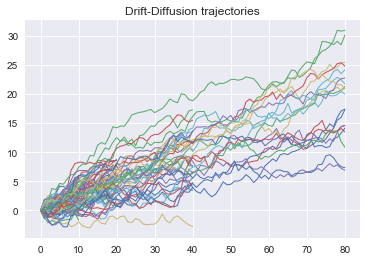

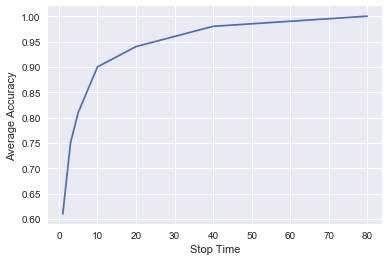

In [25]:

mu = 1.0  # mean of gaussian
sig = 3.0  # std of gaussian 
num_repeats = 100  # number of simulations to run for each stopping time 
stop_time_list = [1,3,5,10,20,40,80]  # list of stopping times to play with
plot_interval = 5   # plot trajectory every 


model = Binary_SPRT_Gaussian1D_FixTime(-mu,sig,mu,sig)
df = pd.DataFrame(columns=["stop_time","decision","evidences"])
fig1,ax1 = plt.subplots(1)
ax1.set_xlabel="Time"
ax1.set_ylabel="Cumulative log likelihood ratio"
ax1.set_title("Drift-Diffusion trajectories")
for stop_time in stop_time_list:
    for i in range(num_repeats):
        dec = model.simulate(stop_time) # run simulation and get decision of current simulation
        df = df.append({
                        'stop_time': stop_time,
                        'decision':dec,
                        'evidences':model.evidence_vec},ignore_index=True)
        if i %plot_interval == 0:
            ax1.plot(model.evidence_vec,lw=1)
plt.show(fig1)

fig2,ax2 = plt.subplots(1)
accuracy = df.groupby(by="stop_time")['decision'].agg(lambda x:sum(x)/len(x))
ax2.plot(accuracy)
ax2.set_xlabel('Stop Time')
ax2.set_ylabel('Average Accuracy')
plt.show(fig2)

---
### EXERCISE 2: Simulate DDM with fixed thresholds

In this exercise, we will use thresholding as our stopping criteria instead. Let's play with different threshold values and observe how average reaction time and accuracy vary with threshold values. 

**Suggestions**
* Complete stopping criteria function based on thresholds
* Complete function to run one simulation given a threshold value 
* Plot speed-accuracy tradeoff, which represents dependency of decision-making accuracy on reaction speed

In [6]:
class Binary_SPRT_Gaussian1D_Threshold(Binary_SPRT_Gaussian1D):
    def __init__(self,mu0,sigma0,mu1,sigma1,alpha=0.05,batch=50): 
        super().__init__(mu0,sigma0,mu1,sigma1)
        self._initialize(alpha)
        self.batch = batch   # observe data points in batch to acclerate code


    def _initialize(self,alpha):
        self.evidence = 0.0 
        self.evidence_vec = np.asarray([0.0])
        self.time = 0
        # threshold related
        self.alpha = alpha
        self.threshold = (1-alpha) / alpha 

    def should_stop(self,):
        return self._should_stop_threshold()

    def _should_stop_threshold(self,):
        return np.any(np.abs(self.evidence_vec) > self.threshold)

    def make_decision(self):
        idx_th = np.argmax(np.abs(self.evidence_vec) >= self.threshold)
        self.evidence_vec = self.evidence_vec[0:idx_th+1]
        self.reaction_time = idx_th
        if self.evidence_vec[idx_th] > 0:
            return 1
        else:
            return 0 

    def simulate(self,threshold=None):
        if threshold is None:
            threshold = self.threshold 
        self._initialize(threshold)
        while not self.should_stop():
            xvec = self.generate_n(1,self.batch)
            self.update_evidence(xvec)
        
        return self.make_decision()

Now let's run some DDM simulations with thresholding stop criteria.

**Suggestions**

* First construct two Gaussian $p_1 = \mathcal{N}(1,3^2)$ and $p_0 = \mathcal{N}(-1,3^2)$. You could also change the signal-to-noise ratio and see what happens.

* Take different confidence levels $\alpha$ and run 500 repeated simulations for each confidence level. 

* For each $\alpha$, calculate the average response speed and average accuracy, and plot them against each other. What does the trend mean?


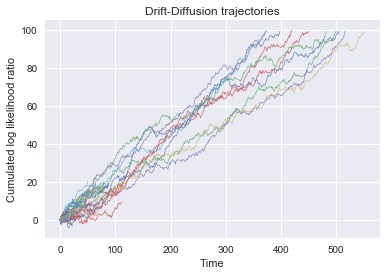

CPU times: user 19.5 s, sys: 97.8 ms, total: 19.6 s
Wall time: 19.7 s


In [14]:
%%time

mu = 1.0  # mean of gaussian 
sig = 3.0  # std of gaussian 
num_repeats = 500  # number of simulations to run for each stopping time 
alpha_list = [0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95]   # list of confidence thresholds
plot_interval = 50  # plot trajectory every 

model = Binary_SPRT_Gaussian1D_Threshold(-mu,sig,mu,sig,batch=100)  # construct a simulation model 
df = pd.DataFrame(columns=["alpha","threshold","decision","reaction_time","evidences"])  # dataframe to store simulation results
fig,ax1 = plt.subplots(1)  # Plot some DDM trajectories
ax1.set_xlabel("Time")
ax1.set_ylabel("Cumulated log likelihood ratio")
ax1.set_title("Drift-Diffusion trajectories")
for alpha in alpha_list:
    for i in range(num_repeats):
        dec = model.simulate(alpha)  # run simulation and get decision of current simulation
        df = df.append({
                        'alpha':alpha,
                        'threshold':model.threshold,
                        'decision':dec,
                        'reaction_time':model.reaction_time,
                        'evidences':model.evidence_vec},ignore_index=True)  # collect simulation results
        if i % plot_interval == 0:
            ax1.plot(model.evidence_vec,lw=0.7,alpha=0.8)
plt.show(fig1)

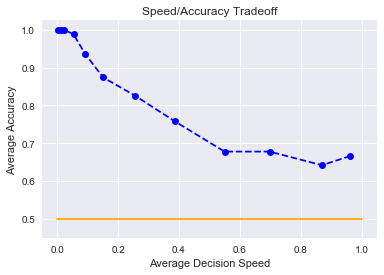

In [24]:


speed = df.groupby(by="alpha")['reaction_time'].agg(lambda x:1.0/np.mean(x,axis=0)) # calculate average reaction speed for each alpha
accuracy = df.groupby(by="alpha")['decision'].agg(lambda x:sum(x)/len(x))  # calculate average accuracy for each alpha

fig3,ax3 = plt.subplots(1)
ax3.plot(speed,accuracy,linestyle="--",marker="o",c='blue')
ax3.plot([0.0,1.0],[0.5,0.5],c='orange')  # plot baseline for random choice
ax3.set_xlabel("Average Decision Speed")
ax3.set_ylabel('Average Accuracy')
ax3.set_title("Speed/Accuracy Tradeoff")
ax3.set_ylim(bottom=0.45)
plt.show(fig3)